In [4]:
#1. Preparación de datos

from keras.datasets import mnist
import numpy as np

def balanced_mnist_set():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  # Normalización de los datos
  x_train = x_train / 255.0
  x_test = x_test / 255.0

  # Balanceo de datos
  idx_y_train_5 = np.where(y_train == 5)[0]
  idx_y_train_n5 = np.where(y_train != 5)[0]
  idx_y_train_n5 = np.random.choice(idx_y_train_n5, idx_y_train_5.shape[0], replace=False)

  idx_y_train = np.concatenate([idx_y_train_5, idx_y_train_n5])
  np.random.shuffle(idx_y_train)

  x_train = x_train[idx_y_train]
  y_train = y_train[idx_y_train]
  #print(x_train.shape)

  idx_y_test_5 = np.where(y_test == 5)[0]
  idx_y_test_n5 = np.where(y_test != 5)[0]
  idx_y_test_n5 = np.random.choice(idx_y_test_n5, idx_y_test_5.shape[0], replace=False)

  idx_y_test = np.concatenate([idx_y_test_5, idx_y_test_n5])
  np.random.shuffle(idx_y_test)

  x_test = x_test[idx_y_test]
  y_test = y_test[idx_y_test]
  #print(x_test.shape)

  y_train_binary = (y_train == 5).astype(int)
  y_test_binary = (y_test == 5).astype(int)
  return (x_train, y_train_binary), (x_test, y_test_binary)

In [5]:
#2. Implementar red neuronal multicapa

from keras.models import Sequential
from keras.layers import Flatten, Dense


(x_train, y_train_binary), (x_test, y_test_binary) = balanced_mnist_set()

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(2, activation='relu'),  # Dos neuronas en la primera capa con activación relu
    Dense(1, activation='sigmoid')  # Una neurona en la segunda capa con activación sigmoid
])

In [6]:
#3. Entrenamiento del modelo
from keras.callbacks import EarlyStopping

# Configuración del Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilación del modelo usando accura
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo con Early Stopping
history = model.fit(
    x_train, y_train_binary,
    epochs=4, verbose=0, batch_size=2000, validation_split=0.9, callbacks=[early_stopping]
)



2024-02-22 23:19:05.653813: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


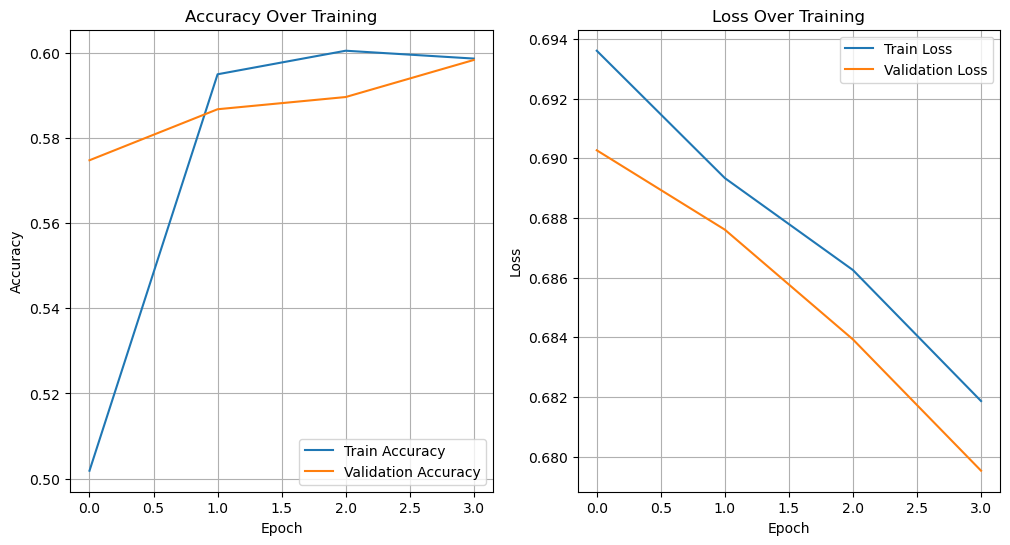

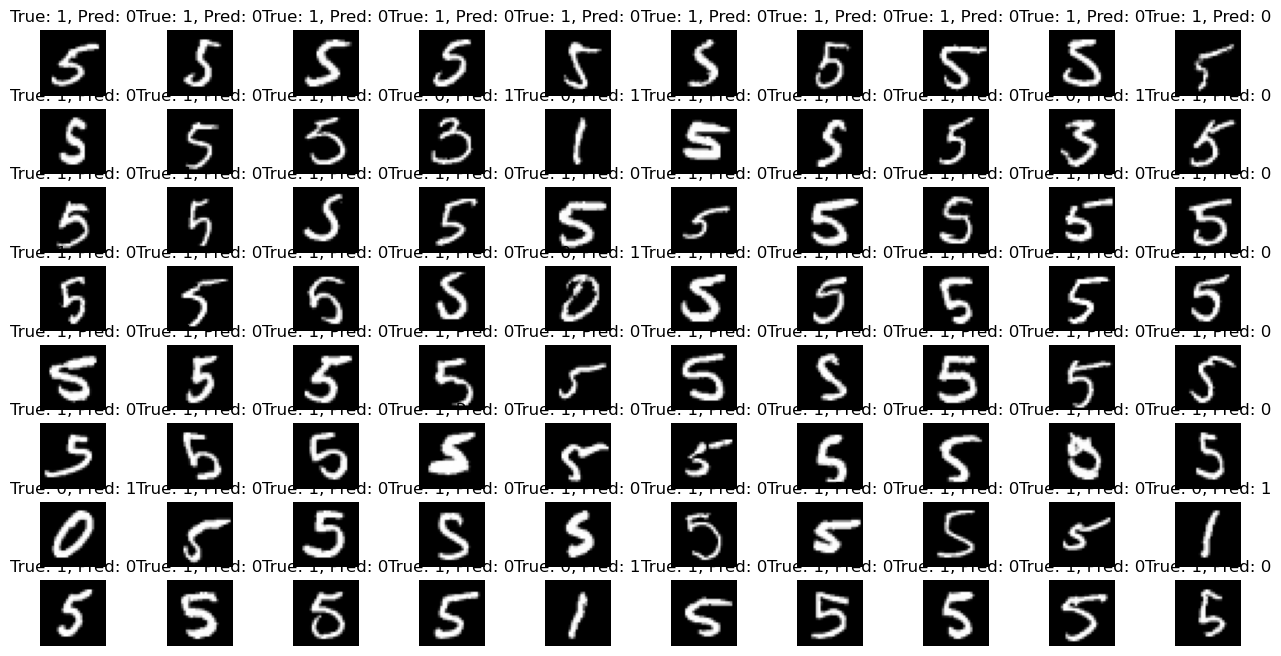

Accuracy: 0.5924887892376681
Precision: 0.8113207547169812
Recall: 0.24103139013452915
F1-Score: 0.3716508210890233

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.94      0.70       892
           1       0.81      0.24      0.37       892

    accuracy                           0.59      1784
   macro avg       0.68      0.59      0.54      1784
weighted avg       0.68      0.59      0.54      1784



In [13]:
#4. Evaluación del modelo

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Graficar el historial de accuracy y loss para el entrenamiento y validación.
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Muestra las imágenes de al menos 80 errores de clasificación del modelo.
y_pred = (model.predict(x_test, verbose=0) >= 0.5).astype(int)[:, 0]
incorrect_idx = np.where(y_pred != y_test_binary)[0][:80]

plt.figure(figsize=(16, 8))
for i, idx in enumerate(incorrect_idx, 1):
    plt.subplot(8, 10, i)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f'True: {y_test_binary[idx]}, Pred: {y_pred[idx]}')
    plt.axis('off')

plt.show()

#Reporte de accuracy, precision, recall y f1-score para ambas clases.
y_pred = (model.predict(x_test, verbose=0) >= 0.5).astype(int)[:, 0]
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

# Reporte detallado
print('\nClassification Report:')
print(classification_report(y_test_binary, y_pred))


56/56 [==============================] - 0s 343us/step


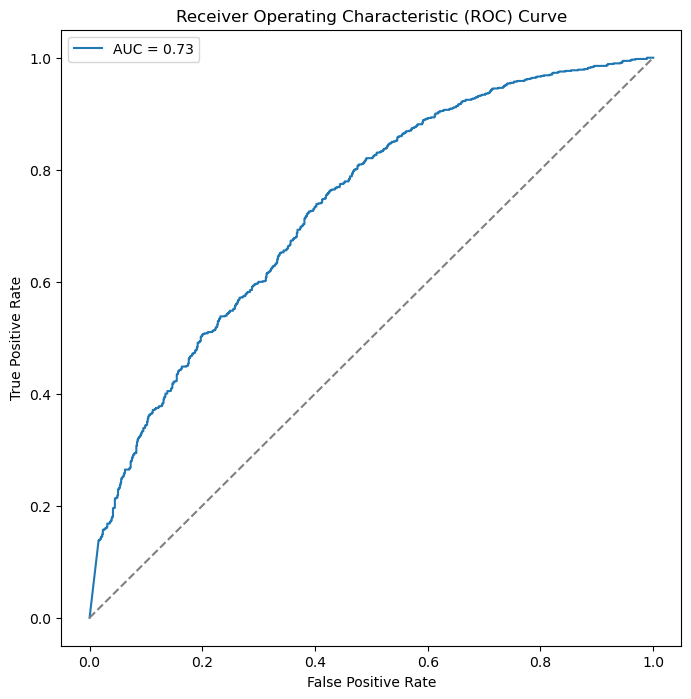

Área bajo la curva ROC (AUC): 0.7317190422087716
Umbral óptimo: 0.48259822


In [16]:
# 5. Grafica la curva ROC del modelo
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

y_pred_prob = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Obtener el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test_binary, y_pred_prob)
print('Área bajo la curva ROC (AUC):', roc_auc)

# Determinar el umbral
# Encontramos el índice del umbral que maximiza la suma de sensibilidad y especificidad
index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[index]

print('Umbral óptimo:', optimal_threshold)
